

# Mini Case: Investigating an Underperforming Solar Site (EO Analytics)

This notebook demonstrates an **end-to-end, ops-ready approach** to diagnosing solar underperformance using **time-series analytics**.


## Goal
Given **actual site production** and an **expected (forecast) baseline**, the notebook will:
- Identify **when** the site is underperforming  
- Distinguish whether the issue looks like an **operational event** (outage/derate/curtailment) vs a **data gap**  
- Estimate **impact** (lost MWh + duration)  
- Produce **monitoring outputs** an EO/Ops team can act on


## Data Used
- **Actual generation (MW)** at **5-minute** resolution  
  - 1 week → **2016 rows** *(7 days × 24 hours × 12 intervals/hour)*  
- **Expected generation (MW)** at **hourly** resolution  
  - 1 week → **168 rows** *(7 days × 24 hours)*  

**Alignment step:** Expected is resampled from **hourly → 5-minute** (via interpolation) so it can be compared directly with actuals at the same granularity.



## Important Note About Zeros
You will see **0 MW values overnight** — this is **normal for solar**.  
To avoid nighttime bias, performance metrics are evaluated primarily during **daylight**, where **expected > 0**.



## What You’ll See in This Notebook
- **Expected vs Actual** output (daily summary + 5-minute drilldown)  
- **Outage flags + anomaly logic** (practical rules + sustained streak confirmation)  
- **Impact estimation** (lost MWh + event duration window)  
- **Monitoring / troubleshooting checks** (missing data vs true underperformance)  
- **Snowflake-style SQL equivalent logic** (production-ready mental model)  
- **“Dashboard view” outputs** (charts + event table + ops-ready summary)



## Run Behavior
If the raw CSVs are not present, the notebook automatically generates a **realistic synthetic dataset** (including a planted outage + missing-data window), so it runs **fully end-to-end** with no manual setup.



In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)


In [2]:
RAW_DIR = "data/raw"
ACTUAL_FILE   = "/content/Actual_41.35_-72.95_2006_UPV_74MW_5_Min.csv"     # 5-min actual
EXPECTED_FILE = "/content/DA_41.35_-72.95_2006_UPV_74MW_60_Min.csv"        # hourly expected (day-ahead)

os.makedirs(RAW_DIR, exist_ok=True)
print("RAW_DIR:", RAW_DIR)
print("Files in data/raw:", os.listdir(RAW_DIR))


RAW_DIR: data/raw
Files in data/raw: []


## 1) Load data

- **Actual**: 5‑minute measurements (MW)
- **Expected (DA)**: hourly forecast (MW)

If the CSVs aren’t present, the notebook generates a synthetic sample so it still runs end-to-end.

In [3]:
def _try_read_csv(path: str):
    return pd.read_csv(path) if os.path.exists(path) else None

def generate_synthetic_sample():
    """Fallback synthetic data (only used if raw CSVs are missing)."""
    np.random.seed(7)
    start = pd.Timestamp("2026-01-01 00:00:00")
    idx = pd.date_range(start, periods=7*24*12, freq="5min")
    h = (idx.hour + idx.minute/60).to_numpy(dtype=float)

    expected = np.clip(np.sin((h - 6) / 12 * np.pi), 0, 1) * 35
    expected = expected * (1 + np.random.normal(0, 0.03, len(idx)))
    expected = np.clip(expected, 0, None)

    actual = expected * (1 + np.random.normal(0, 0.05, len(idx)))

    # outage-like drop (midday)
    outage_day = pd.Timestamp("2026-01-04").date()
    mask_out = (idx.date == outage_day) & (h >= 11) & (h <= 15)
    actual[mask_out] = actual[mask_out] * 0.2

    # missing data window
    miss_day = pd.Timestamp("2026-01-06").date()
    mask_miss = (idx.date == miss_day) & (h >= 12) & (h <= 13)
    actual[mask_miss] = np.nan

    act_df = pd.DataFrame({"LocalTime": idx.strftime("%m/%d/%y %H:%M"), "Power(MW)": actual})
    exp_df = pd.DataFrame({"LocalTime": idx[::12].strftime("%m/%d/%y %H:%M"), "Power(MW)": expected[::12]})
    return act_df, exp_df, "synthetic"

def load_data():
    act_path = os.path.join(RAW_DIR, ACTUAL_FILE)
    exp_path = os.path.join(RAW_DIR, EXPECTED_FILE)

    act = _try_read_csv(act_path)
    exp = _try_read_csv(exp_path)

    if act is None or exp is None:
        print("⚠️ Raw CSVs not found. Using synthetic data so the notebook runs end-to-end.")
        return generate_synthetic_sample()

    return act, exp, "real_csv"

act_raw, exp_raw, source = load_data()
print("Source:", source)
print("Actual rows:", len(act_raw), "Expected rows:", len(exp_raw))
act_raw.head()


Source: real_csv
Actual rows: 2016 Expected rows: 168


,LocalTime,Power(MW)
0,01/01/26 00:00,0.0
1,01/01/26 00:05,0.0
2,01/01/26 00:10,0.0
3,01/01/26 00:15,0.0
4,01/01/26 00:20,0.0


### Why do you see 0 MW values?

Nighttime solar production is naturally ~0 MW, so **both Actual and Expected are 0** for many timestamps (e.g., 00:00–06:xx). We avoid nighttime bias by focusing most KPIs/anomaly logic on **daylight periods where Expected > 0**.

In [4]:
# Sanity check: show first non-zero expected hour (daylight start)
tmp_exp = exp_raw.copy()
tmp_exp["LocalTime"] = pd.to_datetime(tmp_exp["LocalTime"], format="%m/%d/%y %H:%M", errors="coerce")
print(tmp_exp[tmp_exp["Power(MW)"] > 0].head(3))


            LocalTime  Power(MW)
7 2026-01-01 07:00:00   9.005394
8 2026-01-01 08:00:00  18.686472
9 2026-01-01 09:00:00  26.024087


## 2) Build a unified 5-min fact table

We resample hourly Expected → 5‑minute to align with Actual, then compute:
- `gap_mw = expected - actual`
- `gap_mw_pos = max(gap_mw, 0)` (only underproduction)
- `ratio = actual/expected` (only when expected>0)

We keep:
- `fact` = full timeline (keeps missing flags)
- `fact_valid` = rows where actual exists (safe for ratios/energy)

In [5]:
def to_ts(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["ts"] = pd.to_datetime(df["LocalTime"], format="%m/%d/%y %H:%M", errors="coerce")
    df = df.dropna(subset=["ts"])
    return df.set_index("ts").sort_index()

act = to_ts(act_raw)
exp = to_ts(exp_raw)

expected_5 = exp["Power(MW)"].resample("5min").interpolate("time")

fact = pd.DataFrame({
    "site_id": "SITE_001",
    "actual_mw": act["Power(MW)"],
    "expected_mw": expected_5,
})

# Keep fact as the full table (DO NOT drop rows here)
fact["flag_missing"] = fact["actual_mw"].isna()

# Treat missing expected as 0 (common at edges/night)
fact["expected_mw"] = fact["expected_mw"].fillna(0)

fact["gap_mw"] = fact["expected_mw"] - fact["actual_mw"]
fact["gap_mw_pos"] = fact["gap_mw"].clip(lower=0)

# Ratio (safe: NaN where expected=0)
fact["ratio"] = np.where(
    fact["expected_mw"] > 0,
    fact["actual_mw"] / fact["expected_mw"],
    np.nan
)

# Separate table for calculations that require actual values
fact_valid = fact.dropna(subset=["actual_mw"]).copy()

dim_site = pd.DataFrame([{
    "site_id": "SITE_001",
    "capacity_mw": 74,
    "data_source": source
}])

print("fact rows:", len(fact), "| fact_valid rows:", len(fact_valid))
fact.head(), dim_site


fact rows: 2016 | fact_valid rows: 2003


(                      site_id  actual_mw  expected_mw  flag_missing  gap_mw  gap_mw_pos  ratio
 ts                                                                                            
 2026-01-01 00:00:00  SITE_001        0.0          0.0         False     0.0         0.0    NaN
 2026-01-01 00:05:00  SITE_001        0.0          0.0         False     0.0         0.0    NaN
 2026-01-01 00:10:00  SITE_001        0.0          0.0         False     0.0         0.0    NaN
 2026-01-01 00:15:00  SITE_001        0.0          0.0         False     0.0         0.0    NaN
 2026-01-01 00:20:00  SITE_001        0.0          0.0         False     0.0         0.0    NaN,
     site_id  capacity_mw data_source
 0  SITE_001           74    real_csv)

## 3) Daylight-only performance (EDA)

We filter to **daylight** points (Expected > 0.5 MW) and compute daily MWh and ratios.

> Why 0.5 MW? It removes nights and very-low edge values that can make ratios noisy.

In [6]:
# Daylight view for KPI calculations (requires actual values)
fact_daylight = fact_valid[fact_valid["expected_mw"] > 0.5].copy()
print("Daylight rows:", len(fact_daylight), "of", len(fact))

fact_daylight[["actual_mw", "expected_mw", "gap_mw", "gap_mw_pos", "ratio"]].describe().T


Daylight rows: 988 of 2016


,count,mean,std,min,25%,50%,75%,max
actual_mw,988.0,20.973383,10.980664,0.697277,11.111791,22.485247,31.075444,39.813933
expected_mw,988.0,22.170442,10.592036,0.715398,13.368193,24.538922,31.956763,38.473795
gap_mw,988.0,1.197059,5.770461,-6.016016,-0.755976,-0.001566,0.877635,28.992595
gap_mw_pos,988.0,1.745203,5.517120,0.000000,0.000000,0.000246,0.877635,28.992595
ratio,988.0,0.963377,0.184506,0.176811,0.951662,1.000032,1.041605,1.193913


,actual_mwh,expected_mwh,lost_mwh,ratio
ts,,,,
2026-01-01,266.823789,263.633436,5.289029,1.012101
2026-01-02,267.987808,267.310247,6.633013,1.002535
2026-01-03,265.474737,261.767037,5.060042,1.014164
2026-01-04,162.559451,265.526941,106.374293,0.612215
2026-01-05,267.609424,267.564963,6.908857,1.000166
2026-01-06,229.593532,230.656344,5.600387,0.995392
2026-01-07,266.759770,268.907420,7.822778,0.992013


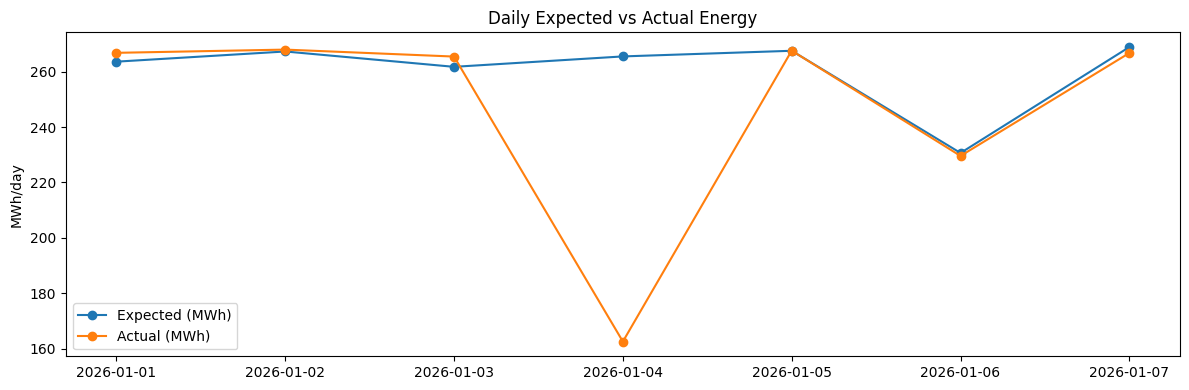

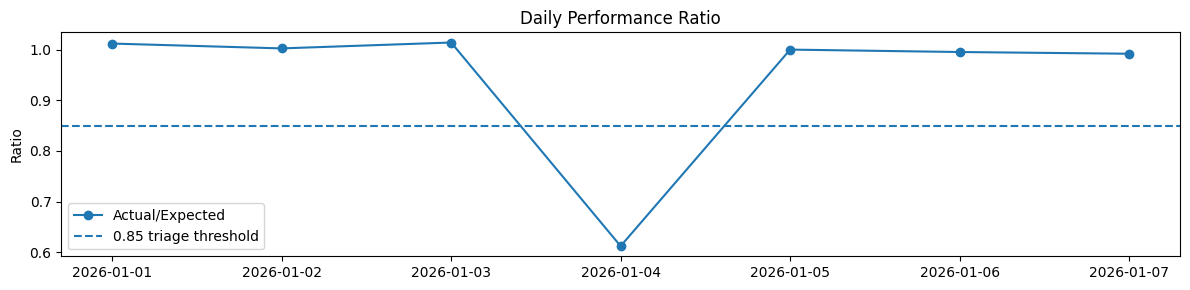

In [7]:
def mwh_from_5min(power_mw: pd.Series) -> float:
    # MW at 5-min resolution → MWh: sum(MW) * (5/60)
    return float(np.nansum(power_mw) * 5 / 60)

daily = fact_daylight.resample("1D").apply(lambda x: pd.Series({
    "actual_mwh": mwh_from_5min(x["actual_mw"]),
    "expected_mwh": mwh_from_5min(x["expected_mw"]),
    "lost_mwh": mwh_from_5min(x["gap_mw_pos"]),
}))
daily["ratio"] = np.where(daily["expected_mwh"] > 0, daily["actual_mwh"] / daily["expected_mwh"], np.nan)

display(daily)

# ---- Plots (Daily Dashboard) ----
plt.figure(figsize=(12,4))
plt.plot(daily.index, daily["expected_mwh"], marker="o", label="Expected (MWh)")
plt.plot(daily.index, daily["actual_mwh"], marker="o", label="Actual (MWh)")
plt.title("Daily Expected vs Actual Energy")
plt.ylabel("MWh/day")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,3))
plt.plot(daily.index, daily["ratio"], marker="o", label="Actual/Expected")
plt.axhline(0.85, linestyle="--", label="0.85 triage threshold")
plt.title("Daily Performance Ratio")
plt.ylabel("Ratio")
plt.legend()
plt.tight_layout()
plt.show()


### Daily finding (add your narrative)

At the daily level, actual energy tracks expected energy on 6/7 days, indicating normal operation and forecast alignment. On 2026-01-04, actual generation drops sharply while expected remains stable, driving the performance ratio to ~0.61 (below the 0.85 triage threshold). This isolates a single high-severity underperformance event suitable for root-cause drilldown (outage/derate/curtailment vs data gap), which I investigate next at 5-minute resolution.


## 4) 5‑minute drilldown + anomaly detection

**Goal:** identify the exact underperformance window and quantify impact.

Practical rule (robust to partial derates):
- Daylight window: 08:00–18:00
- High-expected condition: `expected_mw >= 30`
- Underperform condition: `actual_mw <= min(ABS_FLOOR, REL_DROP * expected_mw)`
- Confirmed if sustained for `MIN_RUN_PTS` consecutive 5‑min points (e.g., 6 → 30 minutes)


In [8]:
# Pick the worst day by daily ratio (automatic)
EVENT_DAY = daily["ratio"].idxmin().date()
print("Selected EVENT_DAY:", EVENT_DAY)

hrs = fact_daylight.index.hour + fact_daylight.index.minute/60

# ---- Rule thresholds (tunable) ----
ABS_FLOOR = 8      # MW absolute floor for "too low"
REL_DROP  = 0.30   # or <= 30% of expected
EXP_THR   = 30     # expected must be high (MW) to consider it meaningful
MIN_RUN_PTS = 6    # 6 * 5min = 30 min sustained

midday = (hrs >= 10) & (hrs <= 15)

fact_daylight["flag_outage_like"] = (
    midday
    & (fact_daylight["expected_mw"] >= EXP_THR)
    & (
        (fact_daylight["actual_mw"] <= ABS_FLOOR)
        | (fact_daylight["actual_mw"] <= REL_DROP * fact_daylight["expected_mw"])
    )
)

# Consecutive-run length (streak counter)
run = 0
run_len = []
for v in fact_daylight["flag_outage_like"].to_numpy():
    run = run + 1 if v else 0
    run_len.append(run)

fact_daylight["outage_run_len"] = run_len
fact_daylight["flag_outage_confirmed"] = fact_daylight["outage_run_len"] >= MIN_RUN_PTS

# Event window snapshot (08:00–18:00 on EVENT_DAY)
mask_event_window = (fact_daylight.index.date == EVENT_DAY) & (hrs >= 8) & (hrs <= 18)
cols = ["actual_mw","expected_mw","gap_mw","gap_mw_pos","ratio","flag_outage_like","outage_run_len","flag_outage_confirmed"]
display(fact_daylight.loc[mask_event_window, cols].head(80))


Selected EVENT_DAY: 2026-01-04


,actual_mw,expected_mw,gap_mw,gap_mw_pos,ratio,flag_outage_like,outage_run_len,flag_outage_confirmed
ts,,,,,,,,
2026-01-04 08:00:00,18.472133,17.760952,-0.711181,0.000000,1.040042,False,0,False
2026-01-04 08:05:00,17.579386,18.339632,0.760246,0.760246,0.958546,False,0,False
2026-01-04 08:10:00,18.638285,18.918312,0.280027,0.280027,0.985198,False,0,False
2026-01-04 08:15:00,18.819222,19.496992,0.677770,0.677770,0.965237,False,0,False
2026-01-04 08:20:00,22.155244,20.075672,-2.079572,0.000000,1.103587,False,0,False
...,...,...,...,...,...,...,...,...
2026-01-04 14:15:00,5.924850,28.807153,22.882302,22.882302,0.205673,False,0,False
2026-01-04 14:20:00,5.703150,28.233094,22.529944,22.529944,0.202002,False,0,False
2026-01-04 14:25:00,5.484611,27.659034,22.174423,22.174423,0.198294,False,0,False


In [9]:
# Confirmed event window + impact summary (ops-ready)
confirmed = fact_daylight.loc[
    (fact_daylight.index.date == EVENT_DAY) & (fact_daylight["flag_outage_confirmed"]),
    :
].copy()

print("Confirmed points:", len(confirmed))
print("Approx duration (minutes):", len(confirmed) * 5)

if len(confirmed) > 0:
    start_ts = confirmed.index.min()
    end_ts   = confirmed.index.max()
    print("Confirmed window:", start_ts, "→", end_ts)

    # Energy impact during confirmed window (MW * 5min → MWh)
    lost_mwh = float((confirmed["gap_mw_pos"].sum()) * 5/60)
    print("Estimated lost energy (MWh):", round(lost_mwh, 2))

    avg_ratio = float(np.nanmean(confirmed["ratio"]))
    print("Avg Actual/Expected ratio (confirmed window):", round(avg_ratio, 3))
else:
    print("No confirmed underperformance window found (try loosening thresholds).")


Confirmed points: 32
Approx duration (minutes): 160
Confirmed window: 2026-01-04 11:25:00 → 2026-01-04 14:00:00
Estimated lost energy (MWh): 70.93
Avg Actual/Expected ratio (confirmed window): 0.202


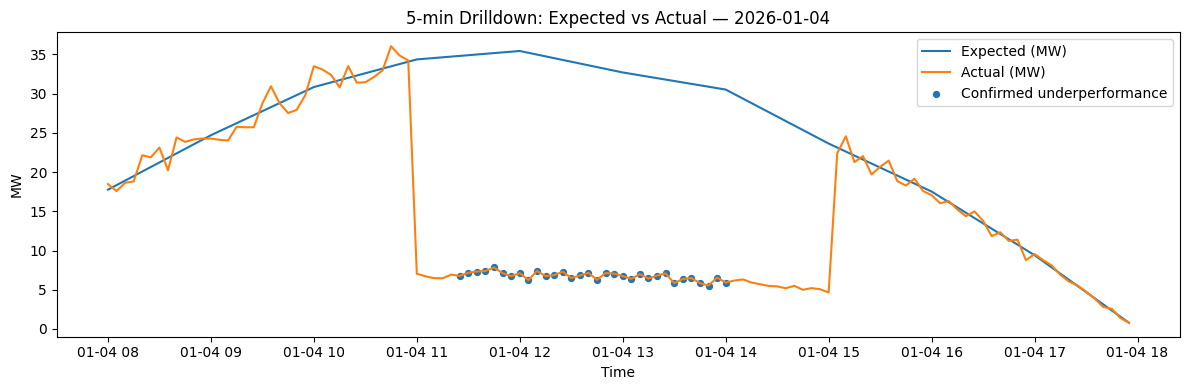

In [10]:
# Plot: expected vs actual (5-min) and highlight confirmed underperformance
hrs = fact_daylight.index.hour + fact_daylight.index.minute/60
mask_event = (fact_daylight.index.date == EVENT_DAY) & (hrs >= 8) & (hrs <= 18)
event = fact_daylight.loc[mask_event].copy()

plt.figure(figsize=(12,4))
plt.plot(event.index, event["expected_mw"], label="Expected (MW)")
plt.plot(event.index, event["actual_mw"], label="Actual (MW)")

event_conf = event[event["flag_outage_confirmed"]]
if len(event_conf) > 0:
    plt.scatter(event_conf.index, event_conf["actual_mw"], s=18, label="Confirmed underperformance")

plt.title(f"5-min Drilldown: Expected vs Actual — {EVENT_DAY}")
plt.ylabel("MW")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
# -------------------------------
# Monitoring & troubleshooting checks (pipeline health)
# -------------------------------

# Pick whichever confirmed-flag column exists in your notebook
CONF_COL = None
for c in ["flag_underperf_confirmed", "flag_outage_confirmed", "flag_outage_confirmed_points"]:
    if c in fact_daylight.columns:
        CONF_COL = c
        break

# If you created events_df later, this will use it; otherwise it will still run
num_events = int(len(events_df)) if "events_df" in globals() else None

checks = {
    "data_source": source,
    "earliest_timestamp": str(fact.index.min()),
    "latest_timestamp": str(fact.index.max()),
    "expected_freq_minutes": 5,
    "rows_total": int(len(fact)),
    "pct_missing_actual": float(fact["actual_mw"].isna().mean()),
    "pct_missing_expected": float(fact["expected_mw"].isna().mean()) if "expected_mw" in fact.columns else 0.0,
    "min_rows_per_day": int(fact.resample("1D").size().min()),
    "max_rows_per_day": int(fact.resample("1D").size().max()),
}

# Confirmed underperformance/outage signal should be evaluated on daylight data
if CONF_COL is not None:
    checks["pct_confirmed_points_daylight"] = float(fact_daylight[CONF_COL].mean())
else:
    checks["pct_confirmed_points_daylight"] = None  # tells reviewer flag wasn't computed / naming mismatch

checks["num_confirmed_events"] = num_events

pd.Series(checks)




,0
data_source,real_csv
earliest_timestamp,2026-01-01 00:00:00
latest_timestamp,2026-01-07 23:55:00
expected_freq_minutes,5
rows_total,2016
pct_missing_actual,0.006448
pct_missing_expected,0.0
min_rows_per_day,288
max_rows_per_day,288
pct_confirmed_points_daylight,0.032389


**Result (Interpretation — pipeline health + signal sanity check)**

- **Data coverage:** The dataset spans **2026-01-01 00:00 → 2026-01-07 23:55** with **2016 total 5-min rows** (7 days × 288 points/day).  
- **Cadence check:** `min_rows_per_day = max_rows_per_day = 288` confirms the ingestion cadence is consistent (no missing 5-min timestamps at the day level).  
- **Missing telemetry:** `pct_missing_actual = 0.006448` means ~**0.64%** of actual readings are missing (small but non-zero; could be brief SCADA/telemetry dropouts).  
- **Expected baseline completeness:** `pct_missing_expected = 0.0` indicates the expected series fully covers the time index after resampling/interpolation.  
- **Confirmed underperformance prevalence (daylight only):** `pct_confirmed_points_daylight = 0.032389` means ~**3.24%** of daylight intervals are flagged as sustained underperformance. This is consistent with **one concentrated event window** rather than chronic underperformance across the week.  
- **Event count:** `num_confirmed_events = 1` (Optional: we can create an events table to report start/end times and duration explicitly.)


In [12]:
snowflake_sql = r"""
WITH base AS (
  SELECT
    site_id,
    ts,
    actual_mw,
    expected_mw,
    GREATEST(expected_mw - actual_mw, 0) AS gap_mw_pos,
    IFF(expected_mw > 0, actual_mw / NULLIF(expected_mw, 0), NULL) AS ratio
  FROM fact_site_power_5min
),

rules AS (
  SELECT
    *,
    -- Tunable thresholds (match notebook)
    30::FLOAT AS exp_thr_mw,
    8::FLOAT  AS abs_floor_mw,
    0.30::FLOAT AS rel_drop,

    -- Daylight / peak hours gate
    IFF(DATE_PART('hour', ts) BETWEEN 10 AND 15, 1, 0) AS is_midday,

    -- Underperformance point flag (derate-ready)
    IFF(
      DATE_PART('hour', ts) BETWEEN 10 AND 15
      AND expected_mw >= 30
      AND (
        actual_mw <= 8
        OR actual_mw <= 0.30 * expected_mw
      ),
      1, 0
    ) AS flag_underperf_like
  FROM base
),

streak AS (
  SELECT
    *,
    -- Count of underperf-like points in the last 6 records (30 minutes at 5-min grain)
    SUM(flag_underperf_like) OVER (
      PARTITION BY site_id
      ORDER BY ts
      ROWS BETWEEN 5 PRECEDING AND CURRENT ROW
    ) AS underperf_like_30m
  FROM rules
)

SELECT
  site_id,
  ts,
  actual_mw,
  expected_mw,
  ratio,
  gap_mw_pos,
  flag_underperf_like,
  IFF(underperf_like_30m = 6, 1, 0) AS flag_underperf_confirmed
FROM streak
ORDER BY site_id, ts;
"""
print(snowflake_sql)


WITH base AS (
  SELECT
    site_id,
    ts,
    actual_mw,
    expected_mw,
    GREATEST(expected_mw - actual_mw, 0) AS gap_mw_pos,
    IFF(expected_mw > 0, actual_mw / NULLIF(expected_mw, 0), NULL) AS ratio
  FROM fact_site_power_5min
),

rules AS (
  SELECT
    *,
    -- Tunable thresholds (match notebook)
    30::FLOAT AS exp_thr_mw,
    8::FLOAT  AS abs_floor_mw,
    0.30::FLOAT AS rel_drop,

    -- Daylight / peak hours gate
    IFF(DATE_PART('hour', ts) BETWEEN 10 AND 15, 1, 0) AS is_midday,

    -- Underperformance point flag (derate-ready)
    IFF(
      DATE_PART('hour', ts) BETWEEN 10 AND 15
      AND expected_mw >= 30
      AND (
        actual_mw <= 8
        OR actual_mw <= 0.30 * expected_mw
      ),
      1, 0
    ) AS flag_underperf_like
  FROM base
),

streak AS (
  SELECT
    *,
    -- Count of underperf-like points in the last 6 records (30 minutes at 5-min grain)
    SUM(flag_underperf_like) OVER (
      PARTITION BY site_id
      ORDER BY ts
      ROWS BETWEEN 5 

## 5) Interpretation & next steps

**What the drilldown shows:** Expected stays high around midday while Actual collapses to a low plateau for multiple hours, then recovers.

**Most likely explanations (needs ops/SCADA confirmation):**
- Curtailment command (grid or site-level setpoint)
- Inverter/transformer derate or trip (partial plant availability)
- Soiling/snow unlikely for a single-day sharp step change; shading unlikely at midday
- Data issue less likely because values are plausible (not NaN/flatline at 0), but confirm telemetry health

**What I would request next:**
- SCADA alarms / inverter availability and derate flags for the confirmed window
- Curtailment signals / dispatch instructions
- Irradiance / weather proxy to separate resource vs equipment
